# Assignment \#2: River Basin Sensitivity Vulnerability and Robustness Analysis

#### Maanav Jhatakia, 5551307

This assignment builds on lab exercise #4.2 where you selected the policies with the best performance across each of the six Nile basin's objectives, as well as two compromise solutions.  For this assignment, we focus on the external factors (the X part of the XLRM diagram), these are factors which are not under our control, yet, they may be influential on the problem's objectives. To this end, you are expected to apply [**exploratory modelling and analysis**](https://www.jstor.org/stable/171847). 

In [1]:
# Importing required packages
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from tqdm import tqdm
from IPython.display import Image

# We need to give permission for connecting to our drive files
from google.colab import drive
#drive.mount('/content/drive')

# Copying the files from our drive folder. The folder name after ../MyDrive/ must match
!cp /content/drive/MyDrive/water_systems -r /content

from water_systems.model_nile import ModelNile
from water_systems import plotter

cp: /content is not a directory


/opt/anaconda3/envs/gds/lib/python3.8/site-packages/google/colab/data_table.py:30: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  from IPython.utils import traitlets as _traitlets


## Defining the states-of-the-world

The idea is to test the Nile sytem model outcomes under a suite of  states-of-the-world (SOWs), this is a fundamental concept in decision analysis which indicates the decision-maker's and modeler's views on uncertainty about the world. In the Nile case, we identify seven uncertain factors that may impact the outcomes of interest.  For each variable, we assume a lower and upper bound described in the following table. 

Uncertain Variable| Baseline value | Range|
------------------|----------------|-------------------------|
Annual demand growth rate| 0.0212| 0.01 - 0.03|
Blue Nile mean inflow coefficient| 1 |0.75 - 1.25|
White Nile mean inflow coefficient| 1 |0.75 - 1.25|
Atbara mean inflow coefficient| 1 |0.75 - 1.25|
Blue Nile deviation coefficient| 1 |0.5 - 1.5|
White Nile deviation coefficient| 1 |0.5 - 1.5|
Atbara deviation coefficient| 1 |0.5 - 1.5|

## Experimental design

In order to sample from among all the uncertain variables simultaneously, we will use [Latin Hypercube Sampling (LHS)](https://en.wikipedia.org/wiki/Latin_hypercube_sampling), which is a multi-dimensional sampling technique. 
Once we have a candidate set of samples, we will run a simulation for each policy and scenario combination.  We will use the [Exploratory Modelling and Analysis (EMA) Workbench](https://emaworkbench.readthedocs.io/en/latest/), run the code below to install and import the required python classes from the ema_workbench. 

In [2]:
!pip install ema_workbench
from ema_workbench import RealParameter, ScalarOutcome, Model, Policy
from ema_workbench import MultiprocessingEvaluator, ema_logging

## Connecting the EMA Workbench with the Nile Model

The code below connects the Nile model with the EMA workbench.  We first specify the problem, the uncertainties, the policy levers, and the outcomes of interest.

In [3]:
# Generating ModelNile object and connecting it to the EMA Workbench:
nile_model = ModelNile()
em_model = Model("NileProblem", function=nile_model)

# Specifying the uncertainties:
em_model.uncertainties = [
    RealParameter("yearly_demand_growth_rate", 0.01, 0.03),
    RealParameter("blue_nile_mean_coef", 0.75, 1.25),
    RealParameter("white_nile_mean_coef", 0.75, 1.25),
    RealParameter("atbara_mean_coef", 0.75, 1.25),
    RealParameter("blue_nile_dev_coef", 0.5, 1.5),
    RealParameter("white_nile_dev_coef", 0.5, 1.5),
    RealParameter("atbara_dev_coef", 0.5, 1.5),
]

# Now the levers and lever ranges. Note that these correspond to RBF parameters!
parameter_count = nile_model.overarching_policy.get_total_parameter_count()
n_inputs = nile_model.overarching_policy.functions["release"].n_inputs
n_outputs = nile_model.overarching_policy.functions["release"].n_outputs
RBF_count = nile_model.overarching_policy.functions["release"].RBF_count
p_per_RBF = 2 * n_inputs + n_outputs # weights- outputs for each input > center and weights.

lever_list = list()
for i in range(parameter_count):
    modulus = (i - n_outputs) % p_per_RBF #parameters per RBF
    if (
        (i >= n_outputs)
        and (modulus < (p_per_RBF - n_outputs))
        and (modulus % 2 == 0)
    ):  # centers:
        lever_list.append(RealParameter(f"v{i}", -1, 1))
    else:  # linear parameters for each release, radii and weights of RBFs:
        lever_list.append(RealParameter(f"v{i}", 0, 1))

em_model.levers = lever_list

# Specify outcomes of interest:
em_model.outcomes = [
    ScalarOutcome("egypt_irr", ScalarOutcome.MINIMIZE),
    ScalarOutcome("egypt_90", ScalarOutcome.MINIMIZE),
    ScalarOutcome("egypt_low_had", ScalarOutcome.MINIMIZE),
    ScalarOutcome("sudan_irr", ScalarOutcome.MINIMIZE),
    ScalarOutcome("sudan_90", ScalarOutcome.MINIMIZE),
    ScalarOutcome("ethiopia_hydro", ScalarOutcome.MAXIMIZE),
]

### Part 1: Running Simulations with each Policy and Scenario Combination

To guarantee good coverage of the uncertainty space, we need to run our simulation under a large set of scenarios.  Your task is to **run 1000 scenarios with at most 5 policies** that you selected in the lab session. Keep in mind that each experiment takes around 2 seconds. So, if you are running 1000*5=5000 combinations, the expected runtime is approximately 10000 seconds (almost 3 hours). You can use the logging function to collect information about the time to completion during the run.

<br>

The function *evaluator.perform_experiments* returns: 
1. A dataframe that stores the experiment details (experiments)
2. A dictionary of arrays of objective values (outcomes)

<br>

**Important Note:** Export your experiment outputs to avoid loosing them when the runtime is restarted.

Tip: Start small, that is, perform a few trial runs with a small number of scenarios and policies, make sure that everything runs as you expect, and that you are able to keep track of the simulation outcomes before you launch a larger experiment. 

##### Note: For purposes of simplicity, I altered the code below slightly. Because I wanted to choose certain indices that provided an interesting range of policy options (and there was a maximum choice of 5 policies), I simply imported the "policies_for_exploration.csv" file and, after dropping the policies that I was not going to simulate, re-indexed and used this new (saved) dataset for the purposes of the simulation below. 

##### The policies that were chosen, in addition to policy indices 6 and 7 (the compromised policies), were policy indices 0, 1, and 4 (which optimized the "Ethiopia Hydropower", "Egypt Irr. Deficit", and "Sudan Irr. Deficit" objectives, respectively). I chose these policies primarily because of two reasons. In Section 1 of the Assignment, we noticed that Sudan and Egypt primarily have one major water body running through the country (that being the Nile River or one of its upstream stems). Therefore, I found that ensuring that irrigation deficits are minimized (which would affect agriculture, subsistence farming, and drinking water availability/effeciveness) needed to be protected as much as possible as compared to "higher level" options like, in Egypt's case, ensuring that the HAD had enough head to generate hydropower. Additionally, for Ethiopia, it made sense to pick the "Ethiopia Hydropower" objective. Not only, in this case, is it Ethiopia's only objective available, but it also benefits from a large number of waterways that run through the country that we saw in the water boundaries map generated in Section 1. Therefore, that objective's optimizing policy was also chosen. 

In [4]:
policies = pd.read_csv("water_systems/policies_for_exploration.csv")

In [5]:
#chosen policies are 0, 1, 4, 6, 7
policies = policies.drop([2,3,5])

In [6]:
policies.reset_index()

,index,v0,v1,v2,v3,v4,v5,v6,v7,v8,...,v155,v156,v157,v158,v159,v160,v161,v162,v163,name
0,0,0.002525,0.200959,0.943539,0.311361,0.298201,0.848421,-0.584362,0.593783,-0.667568,...,0.033126,0.775771,0.228104,0.727064,0.766159,0.187258,0.618653,0.702984,0.856284,Max. Ethiopia Hydropower
1,1,0.002770,0.766593,0.250628,0.311287,0.289713,0.827933,-0.589742,0.442659,0.317202,...,0.001862,0.758667,0.105407,-0.061780,0.687740,0.186733,0.617508,0.726078,0.066627,Min. Egypt Irr. Deficit
2,4,0.083398,0.811615,0.448426,0.311181,-0.648170,0.848386,-0.548515,0.121625,-0.575760,...,0.001687,-0.355223,0.109873,0.692396,0.659389,0.186655,0.618340,0.928154,0.131012,Min. Sudan Irr. Deficit
3,6,0.000429,0.814808,0.890851,0.300520,0.480808,0.847421,-0.585757,0.440793,0.367824,...,0.012659,0.776031,0.129913,0.724901,0.154506,0.760551,0.600791,0.290019,0.160386,Comp Policy 1 - 70
4,7,0.006104,0.813281,0.449221,0.311686,0.279911,0.848218,-0.586211,0.132893,0.258406,...,0.001785,-0.606166,0.187689,0.701973,0.690343,0.183248,0.616853,0.717607,0.089046,Comp Policy 2 - 345


##### I now import the new "updated" policies that are chosen for further exploration.

In [7]:
policies.to_csv('water_systems/policies_chosen_for_exploration.csv')

##### Running the simulation. Please note, due to the amount of time that it takes, I saved the results (experiments, outcomes) from this run of 5000 experiments and collapsed the output. I won't be running this step again when restarting the kernel because I have already imported the results below, but the code here does work.

In [ ]:
from ema_workbench import save_results

# Number of scenarios to be sampled from the uncertainty ranges
n_scenarios = 1000

# Read the policies we prepared during the lab session
policy_df = pd.read_csv('water_systems/policies_chosen_for_exploration.csv')
my_policies = [
    Policy(policy_df.loc[i, "name"], **(policy_df.iloc[i, :-1].to_dict()))
    for i in policy_df.index
]

# Turning on logging to get informed during the run
ema_logging.log_to_stderr(ema_logging.INFO)

with MultiprocessingEvaluator(em_model) as evaluator:
    experiments, outcomes = evaluator.perform_experiments(
        n_scenarios, # Integer input means EMA will sample this many scenarios for us
        my_policies # Policy objects as input means it will run the sampled scenarios with each of the policies
    )

In [18]:
results = experiments, outcomes

In [20]:
save_results(results, '1000 scenarios 5 policies.tar.gz')

[MainProcess/INFO] results saved successfully to /Users/maanavjhatakia/Documents/Python.nosync/Assignment2/TPM802-Model-based-water-systems-assessment/1000 scenarios 5 policies.tar.gz


### Part 2: Global Sensitivity Analysis

In this part, we will examine the sensitivity of the outcomes of interest to  uncertain conditions and to the policy selection. Building on the outcomes generated in Part 1, we will infer variable significance, that is, which factor matters the most influence in our outcomes of interest.  There are a number of machine learning techniques to generate these insights. EMA Workbench supports [feature scoring](https://emaworkbench.readthedocs.io/en/latest/indepth_tutorial/open-exploration.html#feature-scoring) which is based on fitting multiple regression/classification trees for the relationship between inputs and outputs. **Calculate the feature scores of all uncertain variables as well as the selection of policy on every outcome of interest**. This corresponds to 8 feature score inputs (7 uncertain veriables + 1 column for the policy selection) and 6 feature score outputs (1 for each objective). Think about the arguments you use while calling the functions that calculate feature scores. You can refer to the [GitHub page](https://github.com/quaquel/EMAworkbench/blob/master/ema_workbench/analysis/feature_scoring.py) which contains the feature scoring source code.  **Reflect** on your findings.  Which factors or combination of factors are the most influential for our analysis?  What are the implications for the Nile system?  What are the potential risks and opportunities for the three countries involved?


In [8]:
#first isolate the uncertainties_of_interest
uncertainties_of_interest = ['atbara_dev_coef', 'atbara_mean_coef','blue_nile_dev_coef',
                            'blue_nile_mean_coef', 'white_nile_dev_coef', 
                             'white_nile_mean_coef','yearly_demand_growth_rate','policy']

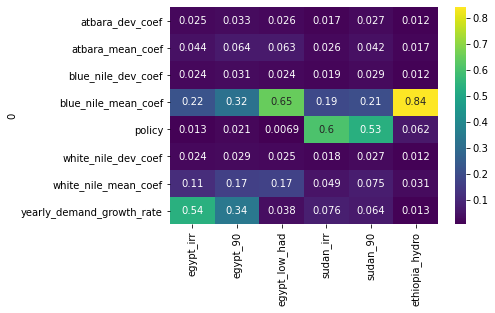

<Figure size 432x288 with 0 Axes>

In [9]:
from ema_workbench import load_results
from ema_workbench.analysis import feature_scoring

#import results that were previously saved from simulation
experiments, outcomes = load_results('1000 scenarios 5 policies.tar.gz')

#perform feature scoring only on uncertanties of interest
x = experiments[uncertainties_of_interest]
y = outcomes

fs = feature_scoring.get_feature_scores_all(x, y)
sns.heatmap(fs, cmap="viridis", annot=True)
plt.show()

#save figure
plt.savefig('feature_score.png')

##### From the plot above, it's clear that the two main factors that have the most influence on outcomes are the Blue River Mean Inflow Coefficient (blue_nile_mean_coef) and the policies themselves (policy). Specifically, "Ethiopia Hydropower" overwhelmingly is impacted from the mean inflow of the Blue Nile stem; this makes sense, as most hydropower generated at GERD in Ethiopia is on-stream of the Blue Nile stem, so inflow would ultimately determine how much hydropower is generated. However, due to its strong reliance on the Blue Nile stem, and seeing how it also is quite influential for the other objectives, Ethiopia runs the risk of exacerbating already existing conflict with downstream riparian countries. This is also supported by the lack of influence of policies in "Ethiopia Hydropower" - therefore, sole reliance is given on inflow. In terms of implications for the greater Nile system, it means that Ethiopia will push hard to keep as much water upstream, meaning that flows downstream will be much more regulated and lower than regular levels. This could also have ecological impacts on the surroundings (impacting areas like agriculture and tourism), and these are impacts that Egypt and Sudan can and should bring up in deterring Ethiopia's opportunity.  

##### Policies are most influential for Sudan's objectives (which, due to each one's definition, would make sense in having similar impacts from different factors). Effectively, this places Sudan in an interesting position, where its irrigation deficit for water is primarily based on real-world negotiations (to ultimately determine a policy(s)). It has some, albeit smaller, impact from the inflow of the Blue Nile stem, but it helps that some of the burden of water deficit can be alliviated due to the convergence of the White Nile stem in Sudan. However, stategically, Sudan can utilize its delicate position to ensure that it is a primary member in negotiations for regulating flows along the Nile. It runs the risk, however, of sidelining its water infrastructure (Sennar and Roseiris dams) in favor of maintaining just enough for irrigation; this could also lead to continued energy dependence on neighboring countries. 

##### Some of the secondary factors with some impact are the White Nile mean inflow (white_nile_mean_coef) and the annual increase in demand, and both of these are combined (along with impact from the Blue Nile inflow coefficient) on impacts in Egypt. The annual demand increase and the Blue Nile inflow have the highest impact on Egypt's Irr. Deficit. Combined with the higher impact of the White Nile inflow for "Egypt Low HAD", Egypt has an advantage that it has multiple stems of water converging upstream, so it has multiple points of failure (i.e a combination of unknown factors) that can deter large-scale damage. However, assuming that demand increases (which the irrigation deficit objective has a large impact from), this could mean tensions with Ethiopia are further exacerbated. Interestingly, the policies do not provide as much of an impact on Egypt's objectives. An opportunity that we currently see is Egypt and Sudan's partnerships on multiple fronts to try and block negative impacts from Ethiopia's usage of Nile river water. This could also help with placing pressure on Ethiopia (perhaps due to estimated economic damage) to work towards a more compromising policy.

### Part 3: Factors contributing to the river basin's goals success or failure. 

Feature scoring tells us how important each variable is in explaining the variability of an outcome of interest. Nonetheless, it does not indicate the direction of influence. In this part, we will investigate how the regions of the uncertainty space are linked to the objective performance. A useful visual method to do so is [dimensional stacking](https://emaworkbench.readthedocs.io/en/latest/indepth_tutorial/open-exploration.html#dimensional-stacking). To generate a dimensional stacking graph, first we need to specify a performance threshold for the objectives, we then classify the outcome values that are lower or higher than our specified threshold. We can then show these results graphically by color coding the regions of the uncertainty space based on the density of classified observations in each region.  Investigate which combination of uncertainties would contribute to the system's vulnerability, and identify opportunities for the outcomes of interest. **Reflect** on what your findings mean for the Nile system and the risks and opportunities for the three countries involved.

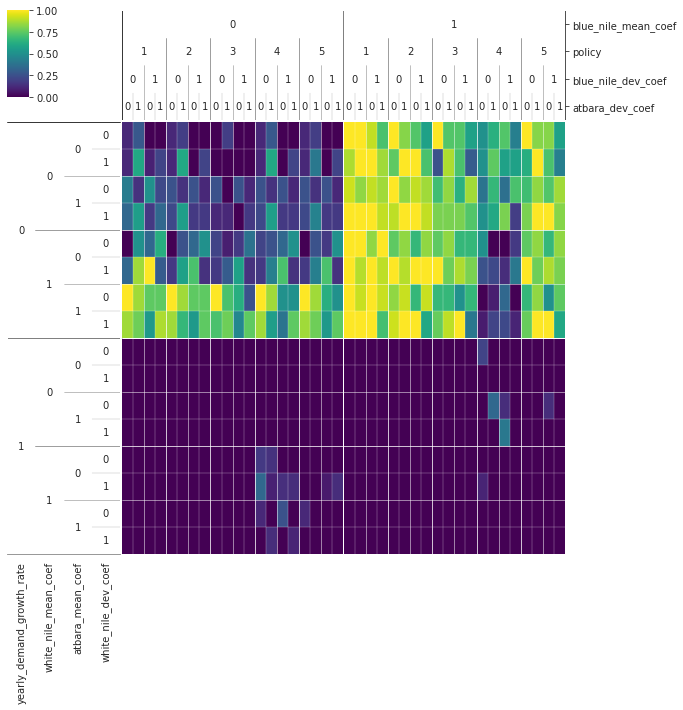

In [10]:
from ema_workbench.analysis import dimensional_stacking

#still utilizing the same uncertainties of interest as above
x = experiments[uncertainties_of_interest]

#setting thresholds for different objectives
perct_25_egy_irr_def = 3.1684
y = outcomes["egypt_irr"] < perct_25_egy_irr_def
dimensional_stacking.create_pivot_plot(x, y, 4, nbins=2)
plt.savefig('egypt_irr_25.png')
plt.show()

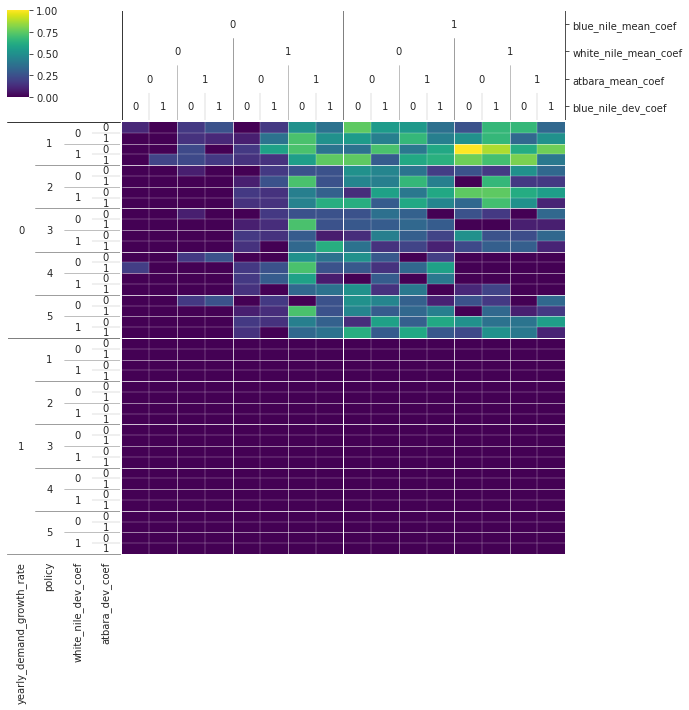

In [11]:
#setting thresholds for different objectives
perct_12_egy_irr_def = 1.16
y = outcomes["egypt_irr"] < perct_12_egy_irr_def
dimensional_stacking.create_pivot_plot(x, y, 4, nbins=2)
plt.savefig('egypt_irr_lower.png')
plt.show()

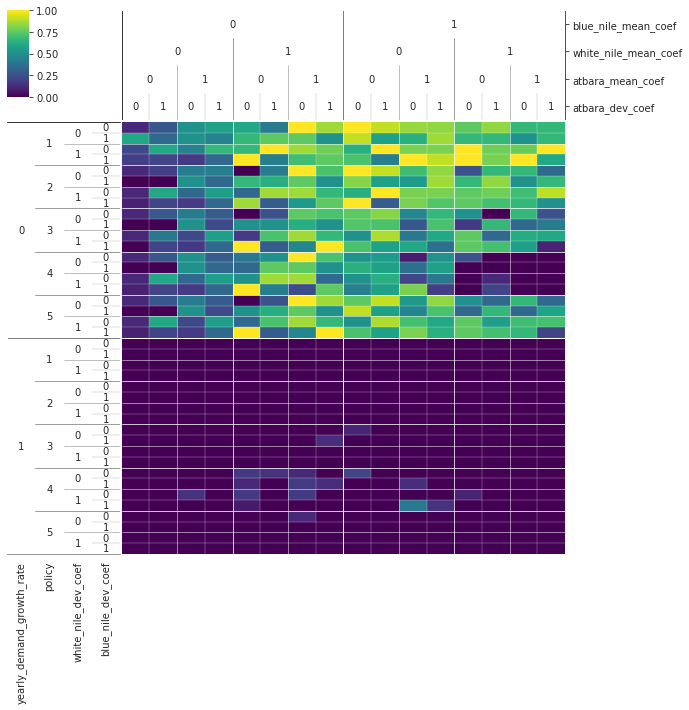

In [12]:
perct_25_egy_90_irr = 0.7196
y = outcomes["egypt_90"] < perct_25_egy_90_irr
dimensional_stacking.create_pivot_plot(x, y, 4, nbins=2)
plt.savefig('egypt_90_irr_25.png')
plt.show()

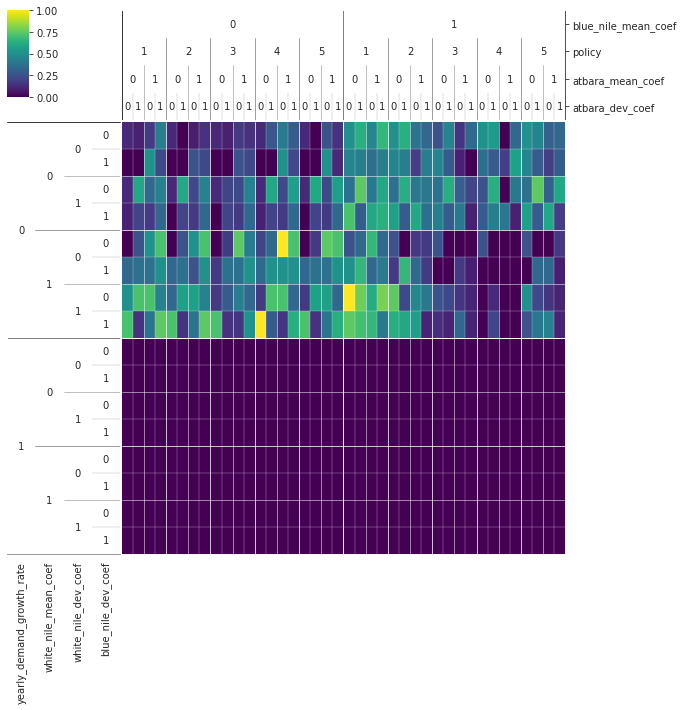

In [13]:
perct_25_egy_90_irr = 0.300
y = outcomes["egypt_90"] < perct_25_egy_90_irr
dimensional_stacking.create_pivot_plot(x, y, 4, nbins=2)
plt.savefig('egypt_90_irr_lower.png')
plt.show()

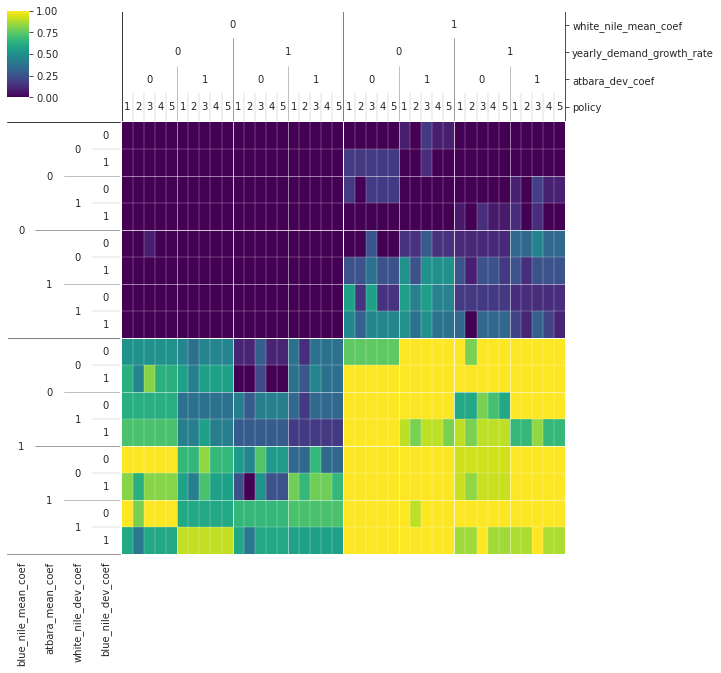

In [14]:
perct_25_egy_low_HAD = 0.075
y = outcomes["egypt_low_had"] < perct_25_egy_low_HAD
dimensional_stacking.create_pivot_plot(x, y, 4, nbins=2)
plt.savefig('egypt_low_had_25.png')
plt.show()

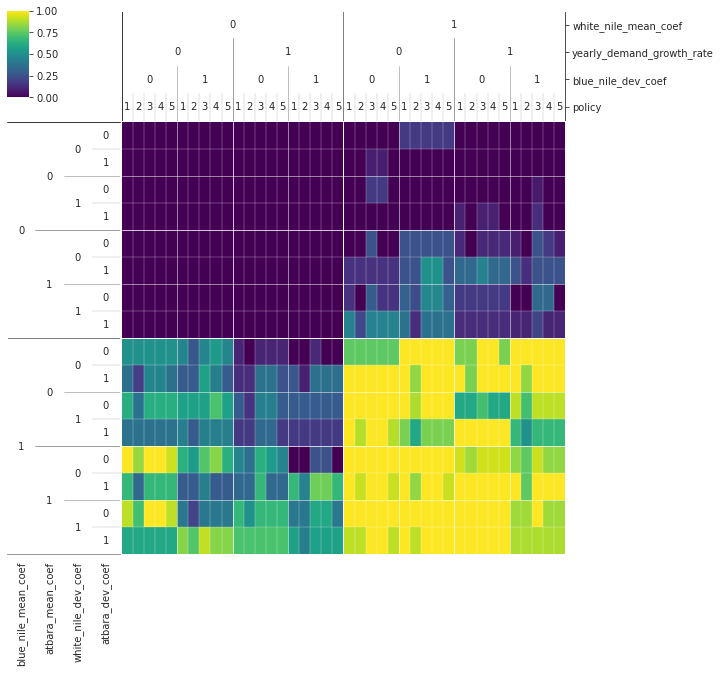

In [15]:
#setting thresholds for different objectives
perct_12_egy_low_HAD = 0.0275
y = outcomes["egypt_low_had"] < perct_12_egy_low_HAD
dimensional_stacking.create_pivot_plot(x, y, 4, nbins=2)
plt.savefig('egypt_low_had_lower.png')
plt.show()

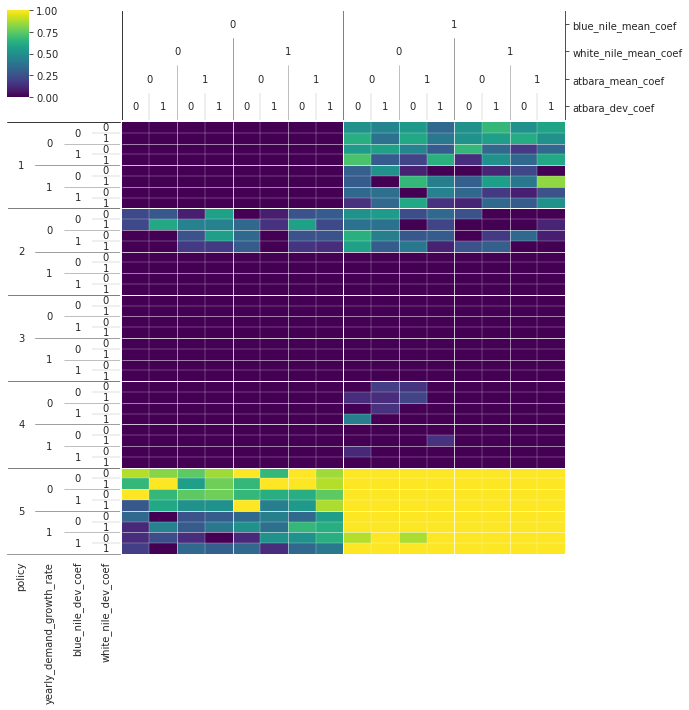

In [16]:
perct_25_sud_irr_def = 0.110130
y = outcomes["sudan_irr"] < perct_25_sud_irr_def
dimensional_stacking.create_pivot_plot(x, y, 4, nbins=2)
plt.savefig('sudan_irr_25.png')
plt.show()

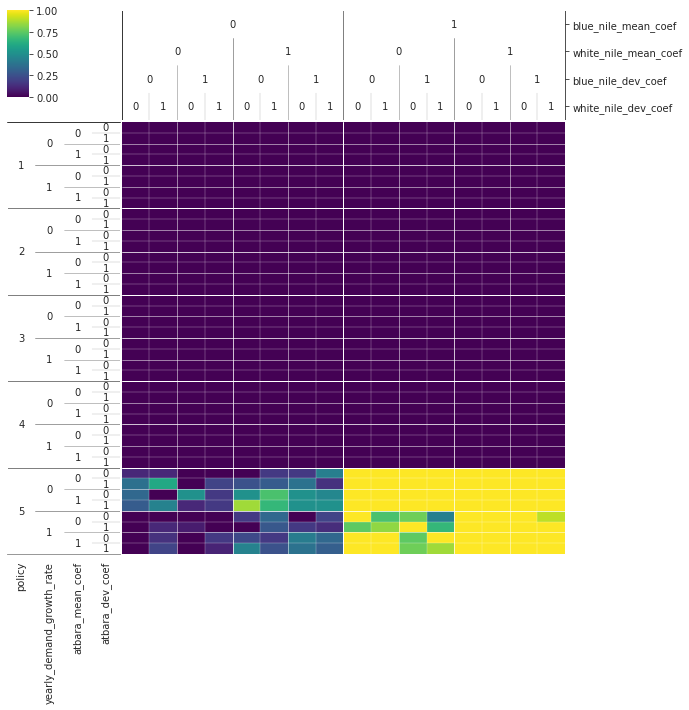

In [17]:
perct_12_sud_irr_def = 0.03
y = outcomes["sudan_irr"] < perct_12_sud_irr_def
dimensional_stacking.create_pivot_plot(x, y, 4, nbins=2)
plt.savefig('sudan_irr_lower.png')
plt.show()

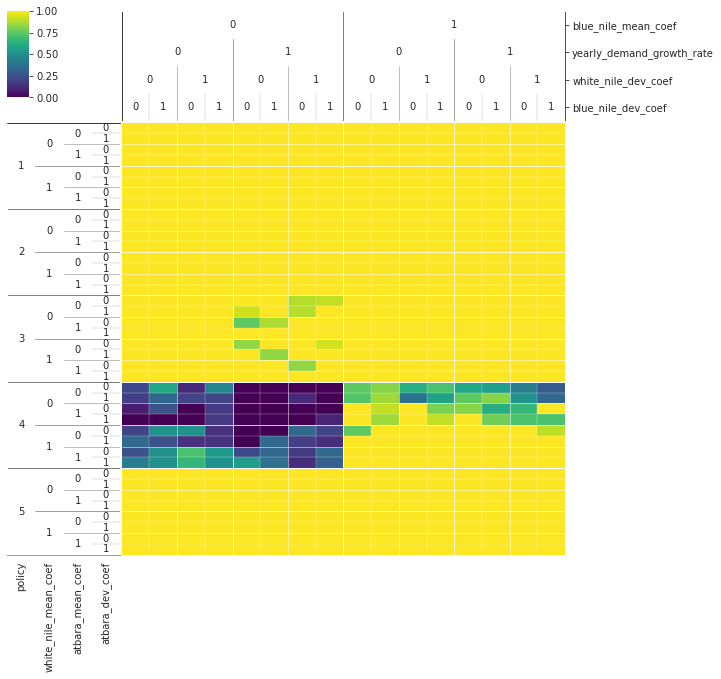

In [18]:
perct_25_sud_90_irr_def = 0.30
y = outcomes["sudan_90"] < perct_25_sud_90_irr_def
dimensional_stacking.create_pivot_plot(x, y, 4, nbins=2)
plt.savefig('sudan_90_irr_25.png')
plt.show()

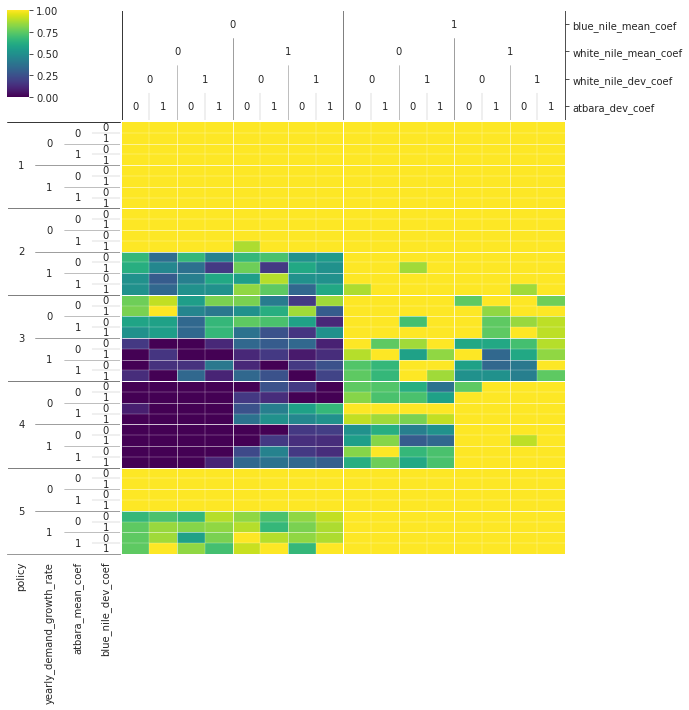

In [19]:
perct_12_sud_90_irr_def = 0.02
y = outcomes["sudan_90"] < perct_12_sud_90_irr_def
dimensional_stacking.create_pivot_plot(x, y, 4, nbins=2)
plt.savefig('sudan_90_irr_lower.png')
plt.show()

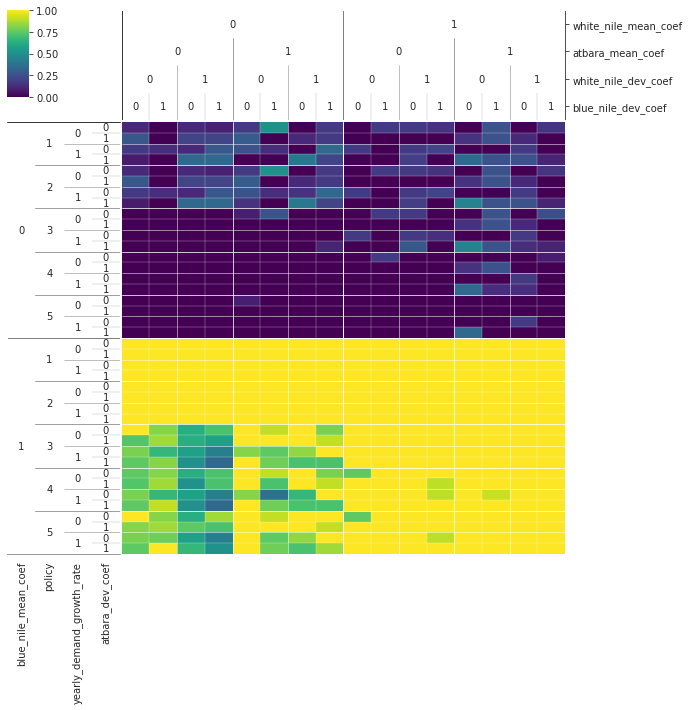

In [20]:
perct_25_eth_hyd = 14.447477
y = outcomes["ethiopia_hydro"] > perct_25_eth_hyd
dimensional_stacking.create_pivot_plot(x, y, 4, nbins=2)
plt.savefig('ethio_hydro_25.png')
plt.show()

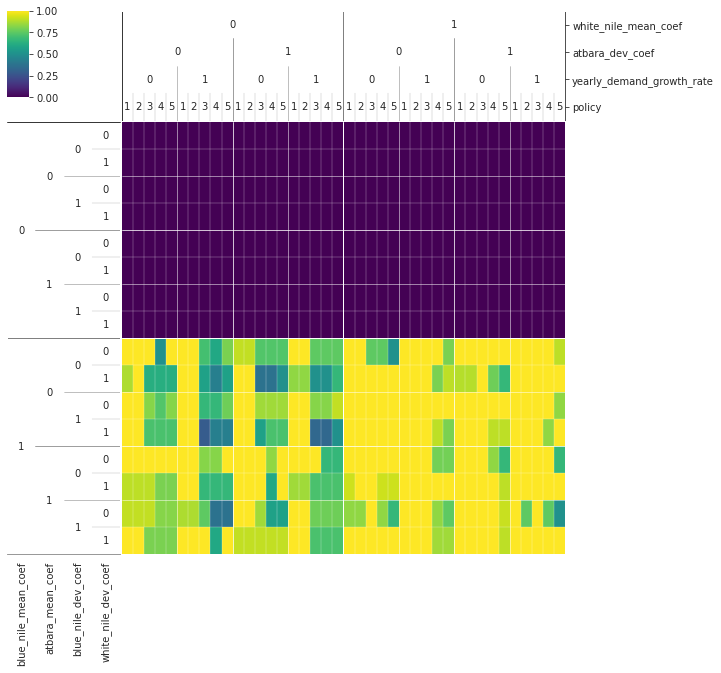

In [21]:
perct_12_eth_hyd = 15.1
y = outcomes["ethiopia_hydro"] > perct_12_eth_hyd
dimensional_stacking.create_pivot_plot(x, y, 4, nbins=2)
plt.savefig('ethio_hydro_lower.png')
plt.show()

##### When analyzing vulnerability analysis, the first step was to create a threshold based on the objectives (i.e setting the parameters of options which can optimize a objective). To do this, I took a lower boundary of the 75th boundary for "ethiopia Hydropower" (so only taking into consideration instances where the value for "Ethiopia Hydropower" was at the 75th percentile and above). For the remaining objectives, since we optimally want to minimize them, the threshold had an upper bound of the 25th percentile. This was done to account for the variability of different objectives but still look only for solutions that provided the "best" outcomes. The same process was used for the second type of threshold- however, the value was altered to make the threshold tighter (i.e closer) to the optimal value.

##### There are several observations made here:  
##### 1. EGYPT: For "Egypt Irr. Deficit", we see that a large concentration of optimal cases are specifically when there is a high Blue Nile mean inflow, high White Nile mean inflow, and a low annual demand growth rate. As seen above, Egypt's objectives have influence from multiple uncertain factors. When the threshold becomes tighter, the concentration of preferred cases start to isolate (albeit lower in magnitude) to instances with a low yearly demand growth rate and high Blue Nile inflow. Influence from the White Nile inflow drops, and while the first threshold seemed to not give a preference on policy, a tighter threshold shifts to an overwhelming preference for Policy 1 (and less so for Policy 2). For "Egypt 90th Irr. Deficit", however, influence from the White Nile mean inflow remains for a tighter threshold band, and Policy 4 (under a high White Nile inflow, low Blue Nile inflow, and low demand growth rate) gives the highest probability of preferred cases. This poses one vulnerablity - considering the Blue Nile mean inflow's influence over all objectives, Egypt's criteria for this objective becomes very rigid - and this can also lead to very unfavorable outcomes in a majority of other conditions. Additionally, "Egypt Low HAD" doesn't really have change in tightening thresholds; it still gives a high number of preferred scenarios if both the Blue/White Nile mean inflows are high. 

##### All of this shows that although several factors exert influence on Egypt's objectives, a tighter threshold pushes Egypt to demand higher Nile inflows, which will certainly face backlash from Ethiopia. Otherwise, Egypt is forced to triage water use, sacrificing its HAD production in favor of maintaining its agriculture industry (or vice versa). An opportunity here would be to see whether Egypt and Ethiopia could negotiate on regulating Nile mean inflow so that beneficial use between the two could be shared for different periods of time (thereby compromising but still seeing benefit for both due to their depedence on these factors). 

##### 2. SUDAN: Sudan's vulnerabilities emerge partially due its geography. As the mid-stream state between two powers both vying for Nile water, Sudan's irrigation deficit largely depends on the policy chosen (assuming high Blue Nile mean inflow). This is a big vulnerability of the system, in that first- and end-users will have the highest power in negotiations due to their demands, but mid-stream states must deal with repercussions of negotiations without much say. A tighter threshold for "Sudan Irr. Deficit" simply concentrates most preferred cases in the event of Policy 5 and high Blue Nile inflow, while the original threshold seemed to also give some favorable cases in Policy 1. While "Sudan 90th Irr. Deficit" seems to show widespread high concentrations, this objective becomes misleading because of the high number of scenarios where optimization is already achieved. Therefore, while this vulnerability exists, Sudan also can use this as an opportunity to partner with Egypt. As most policies will give a disadvantage to Sudan's objectives, its geographical position to (i.e upstream to Egypt) allows it to seek some sort of compensation of assistance from Egypt in the event of a harmful policy choice. 

##### 3. ETHIOPIA: High Blue Nile inflow overwhelmingly is preferred for Ethiopia, regardless of threshold. While a high White Nile inflow value adds to the high concentration of preferred cases, scenarios with a high Blue Nile inflow provide significantly high concentrations on their own. When tightening the threshold, preference moves to Policies 1 and 2 (with 3 being an option with high White Nile inflow). This is similar to Egypt, which could present an opportunity for negotiation, but this will also severely disadvantage Sudan in the middle, which could lead to complications. 

### Part 4. Robustness of Policies

An essential tool for decision making under deeply uncertain conditions is [robust decision making (RDM)](https://link.springer.com/chapter/10.1007/978-3-030-05252-2_2). The main philosophy behind the RDM approach is to stress-test the performance of policies under many alternative states of the world and identify the ones that lead to robust performance across all scenarios. Several [metrics to quantify robustness](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/2017EF000649) are available.  Calculate the robustness score for each policy with respect to a metric you choose and show your results graphically.  Is it possible to recommend a policy based on this analysis? What are the underlying assumptions for the analysis you conducted and for your recommendations to be valid?

In [22]:
#please note that for the code for this portion, some help was taken for 
#maximum regret calculations from the EPA1361- Model-based DM course (Asg. 8 & final project)

reg_overall = {}
reg_max = {}

#for loop to run over each scenario (5000)
for outcome in em_model.outcomes: #for each outcome that was run in the simulation above
    policycol = experiments['policy'] #the choice of policy
    # create a DataFrame with all the relevent information {outcome scores, the policy, and scenario value}
    data = pd.DataFrame({outcome.name: outcomes[outcome.name], 
                         "policy": policycol,
                         "scenario": experiments['scenario']})
    
    # reorder the dataframe to index based on the scenario + flatten index from pivoting
    data = data.pivot(index='scenario', columns='policy')
    data.columns = data.columns.get_level_values(1)
    # maximum across the row minus the actual values in the row (absolute value)
    outcome_regret = (data.max(axis=1)[:, np.newaxis] - data).abs()
    #appending the dictionary key above with calculated infomation (new values)
    reg_overall[outcome.name] = outcome_regret
    reg_max[outcome.name] = outcome_regret.max()
    

/var/folders/fv/w_4_6lgj0pg873rfkcnj0z7c0000gn/T/ipykernel_41420/2739360770.py:19: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  outcome_regret = (data.max(axis=1)[:, np.newaxis] - data).abs()


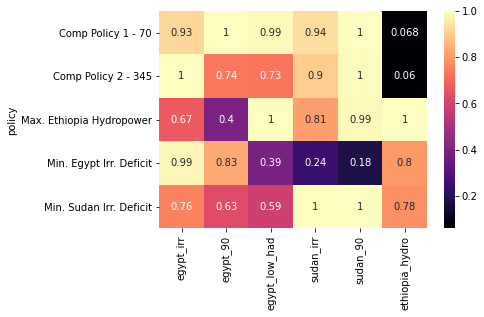

In [23]:
reg_max = pd.DataFrame(reg_max)
# standardizing based on maximum regret
sns.heatmap(reg_max/reg_max.max(), cmap='magma', annot=True)
plt.show()

In [24]:
#please note while I checked the code and the mathematics behind the code, the results above still seem
# to be a bit confusing. I may have done this portion wrong, but my analysis will assume that the above 
# is correct. 

In [25]:
reg_max

,egypt_irr,egypt_90,egypt_low_had,sudan_irr,sudan_90,ethiopia_hydro
policy,,,,,,
Comp Policy 1 - 70,4.358515,3.094497,0.520833,2.630899,1.431550,0.310033
Comp Policy 2 - 345,4.708934,2.275413,0.383333,2.525718,1.426130,0.272477
Max. Ethiopia Hydropower,3.155532,1.225189,0.525000,2.276769,1.419420,4.575638
Min. Egypt Irr. Deficit,4.648448,2.561276,0.204167,0.683295,0.255611,3.638120
Min. Sudan Irr. Deficit,3.556104,1.957540,0.308333,2.806411,1.431550,3.571639


##### Maximum regret was the robustness metric chosen for this system, taken from the paper from McPhail et al. (2018). The maximum regret is determined as the difference between the performance of a particular option and the best possible option's performance of a solution. Regret is a good metric to use in this situation, particularily to see how much of a difference we can see across different objectives. It also provides good insight, like in the case for Egypt, on trade-offs that may be experienced within a country with the implementation of a specific policy. Given this, maximum regret also is appropriate for the Nile river system. McPhail et al. (2018) details that maximum regret, as a robustness metric, is appropriate when metrics are based on actual performance values. Because of the definition of maximum regret, higher values indicate a more regretful policy per objective relative to other policies (due to standardization by dividing by the maximum regret value).

##### From the heatmap above, several observations can be made. The policy of "Max. Ethiopia Hydropower" (Policy 1) seems to be the most regretful across the objectives, including for "Ethiopia Hydropower". Note, however, that there are limitations to this observation. First, from the initial analysis done in Section 1, this objective was considered to be the most volatile in values. Therefore, a large range of values could have occured, which would elevate the relative maximum regret. However, seeing that it is the most regretful for half of all objectives, we can eliminate this from the choice of final policy recommendations. The same can be said about Policy 4, or Comp. Policy 1 (70). It disproportionately favors Ethiopia while being very regretful for both Egypt and Sudan's objectives. As discussed in Section 3, due to the nature of the system, there will be clear trade-offs between countries regardless of the policy. 

##### A policy from the list above that seems the most plausible is Policy 2 (or Min. Egypt Irr. Deficit). Other than the skewed benefit that Policy 1 gave to Ethiopia, Policy 2 provides the lowest overall regret across many of the policies, indicating that it has significant robustness and can be a beneficial solution to most stakeholders. It also provides similar regret to both Egypt (specifically its 90th Irr. Deficit) and for "Ethiopia Hydropower", although these are much higher. Additionally, when looking above, we see that Sudan's objectives, which correlate to the highest robustness for Policy 2, seem to be dependent on policy outcome to recieve the most desired outcomes of objectives. Other objectives are affected many other items. Therefore, while it is not the ideal scenario, we are able to give a recommendation. 

##### In terms of assumptions, we assume high Blue Nile and White Nile mean inflow levels - these are conditions that, in the vulnerability analysis, provided the greatest concentration of beneficial outcomes. For the calculation above, I also never defined boundaries or thresholds for objectives that, if they meet, are able to allow for water to flow to the benefit of downstream users. Therefore, the robustness metrics above assume maximum optimization for an objective. Furthermore, this also assumes that all scenarios that are tested are relevant/possible scenarios in a real-life scale, which is important for accurate decision-making (Lempert, 2019). 